In [1]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 8.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm
import arviz as az

from gensim import corpora
from gensim.models import LdaModel

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Q1

In [3]:
# DO NOT MODIFY THIS CODE
website_visits_data = np.loadtxt('https://raw.githubusercontent.com/MIE223-2024/course-datasets/main/website_visits.csv', delimiter=',')

## (a)

80


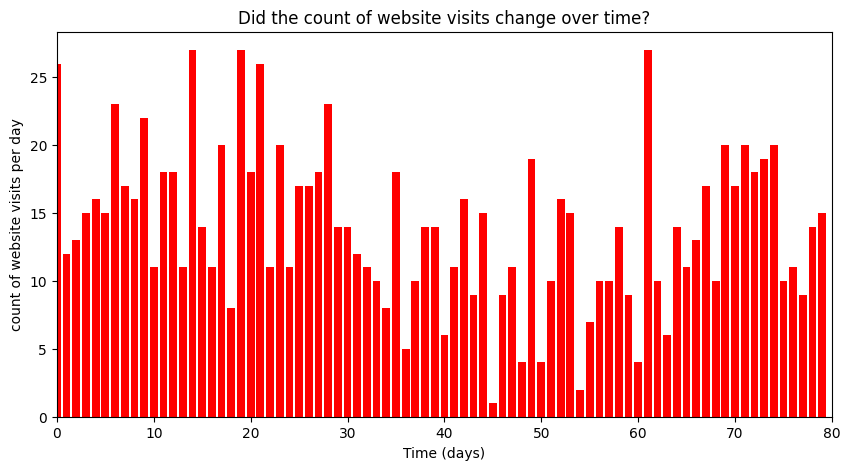

In [4]:
# YOUR CODE STARTS HERE
# Plot text messages received over time
n_website_count_data = len(website_visits_data)
plt.figure(figsize=(10,5))
plt.bar(np.arange(n_website_count_data), website_visits_data, color="red")
plt.xlabel("Time (days)")
plt.ylabel("count of website visits per day")
plt.title("Did the count of website visits change over time?")
plt.xlim(0, n_website_count_data);
print(n_website_count_data)

**Enter your answer here:** In the barplot above we observe a high count before the 36 day visit count which means there is a switchpoint and then we also start to see a high count again at the 60+ day. These are points were there are very abrupt changes.

## (b)

In [14]:
# DO NOT MODIFY THIS CODE

param_names = ['tau_1', 'tau_2', 'lambda_1', 'lambda_2', 'lambda_3']

double_switchpoint_model = pm.Model()

with double_switchpoint_model:

  # Define priors
  # YOUR CODE STARTS HERE (FILL IN THE BLANKS)
  alpha = 1/np.mean(website_visits_data)
  tau_1 =  pm.DiscreteUniform("tau_1", lower=0, upper=n_website_count_data-1)
  tau_2 =  pm.DiscreteUniform("tau_2", lower=0, upper=n_website_count_data-1)
  lambda_1 = pm.Exponential("lambda_1",alpha)
  lambda_2 = pm.Exponential("lambda_2", alpha)
  lambda_3 = pm.Exponential("lambda_3", alpha)
  idx = np.arange(n_website_count_data)
  lambda_12 = pm.math.switch(idx < tau_1, lambda_1, lambda_2)
  lambda_ = pm.math.switch(idx < tau_2, lambda_12, lambda_3)


  # Define likelihood (conditioned on observed data)
  # YOUR CODE STARTS HERE (FILL IN THE BLANK)
  likelihood = pm.Poisson("visits", lambda_, observed= website_visits_data)

  # Sample from posterior
  # YOUR CODE STARTS HERE (FILL IN THE BLANK)
  trace = pm.sample(1000, random_seed = 45)

## (c)

In [15]:
# Function to: (a) plot histogram of posterior samples (b) display mean and 94% HDI of posterior samples

def plot_posterior(param_name, trace):

   # (a) Plot histogram of posterior samples of passed parameter
    # YOUR CODE STARTS HERE
    ax = sns.histplot(trace.posterior[param_name].values.flatten())
    ax.set_xlim(0, n_website_count_data)
    plt.xlabel(param_name)
    plt.ylabel('Number of Samples')
    plt.title('Histogram of Posterior Samples of ' + param_name)

    # (b) Display mean and 94% HDI of posterior samples of passed parameter (round to 2 decimal places)
    # YOUR CODE STARTS HERE
    print(f"\nMean of {param_name}: {np.mean(trace.posterior[param_name].values.flatten())}")
    hdi = az.hdi(trace.posterior[param_name].values.flatten())
    print(f"94% HDI of {param_name}: {hdi}")

    return None


Mean of tau_1: 50.7435
94% HDI of tau_1: [22 76]


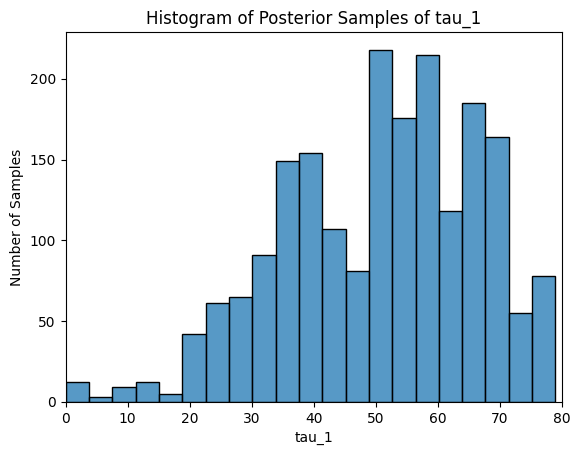


Mean of tau_2: 29.7645
94% HDI of tau_2: [27 33]


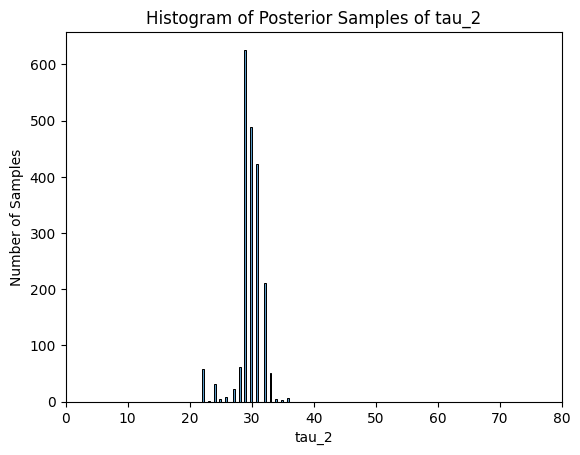


Mean of lambda_1: 17.098343652400036
94% HDI of lambda_1: [15.62738205 18.42165738]


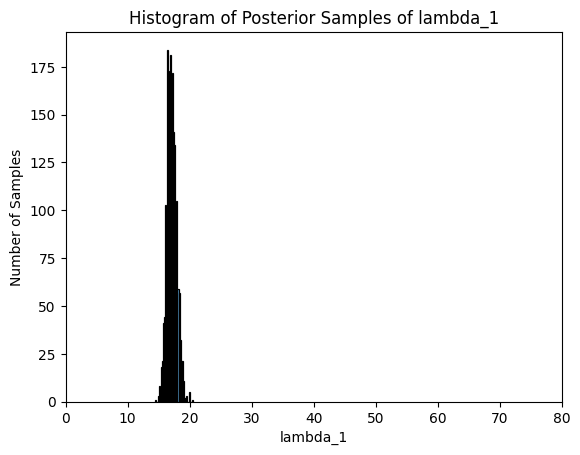


Mean of lambda_2: 13.697108160073366
94% HDI of lambda_2: [1.67208128e-03 3.70375633e+01]


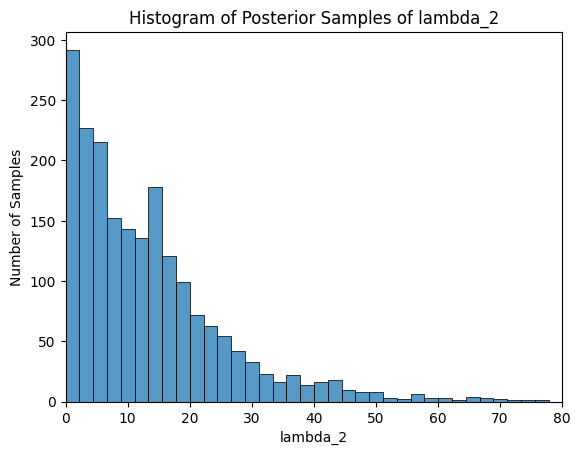


Mean of lambda_3: 12.046920571124968
94% HDI of lambda_3: [11.08642295 12.9141061 ]


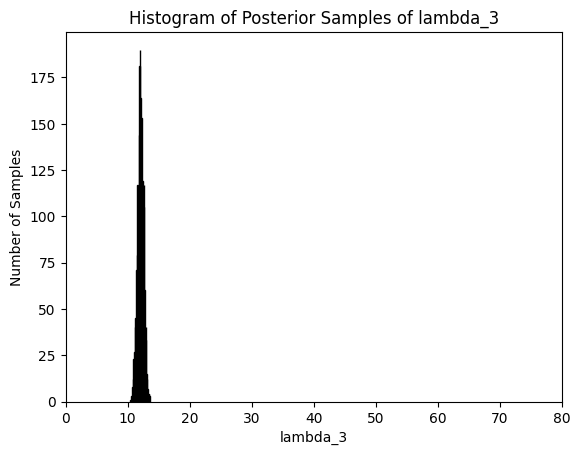

In [16]:
# DO NOT MODIFY THIS CODE
for param_name in param_names:
    plot_posterior(param_name, trace)
    plt.show()

**Enter answer here:**

i) The current model is not a good fit for the model because the ranges of HDI are wide so there is not a lot of confidence for the posterior.
Since lambda 2 is greater than lambda 3 there should be a decrease in the website visits, however this does not align with the trend observed in (a).
ii) The histograms of the posterior samples do not align because switchpoint beliefs are not concentrated around our expectations from the observed trends.

## (d)

In [17]:
# DO NOT MODIFY THIS CODE
param_names = ['tau_1', 'tau_2', 'lambda_1', 'lambda_2', 'lambda_3']

double_switchpoint_model_adjusted = pm.Model()

with double_switchpoint_model_adjusted:

  # Define priors
  # YOUR CODE STARTS HERE
  alpha = 1/np.mean(website_visits_data)
  tau_1 =  pm.DiscreteUniform("tau_1", lower=0, upper=n_website_count_data-1)
  tau_2 = pm.DiscreteUniform("tau_2", lower= tau_1, upper=n_website_count_data-1)
  lambda_1 = pm.Exponential("lambda_1",alpha)
  lambda_2 = pm.Exponential("lambda_2", alpha)
  lambda_3 = pm.Exponential("lambda_3", alpha)
  idx = np.arange(n_website_count_data)
  lambda_12 = pm.math.switch(idx < tau_1, lambda_1, lambda_2)
  lambda_ = pm.math.switch(idx < tau_2, lambda_12, lambda_3)

  # Define likelihood (conditioned on observed data)
  # YOUR CODE STARTS HERE
  likelihood = pm.Poisson("visits", lambda_, observed= website_visits_data)

  # Sample from posterior
  # YOUR CODE STARTS HERE
  trace_adjusted = pm.sample(1000, random_seed = 45)

**Enter your answer here:** The lowerboundfor Tau_2 is now tau_1 as suppose to 0. This helps with bounds for the model

## (e)


Mean of tau_1: 30.687
94% HDI of tau_1: [29 33]


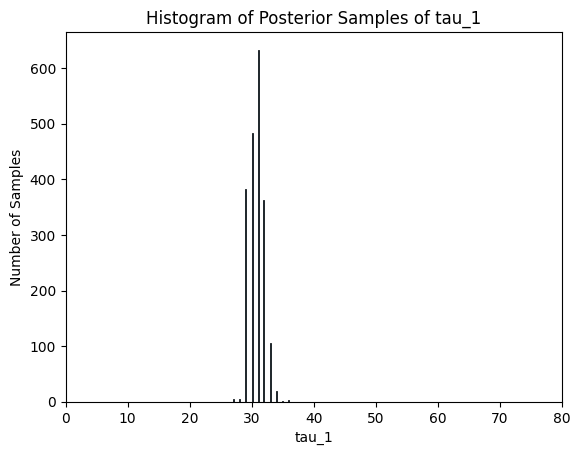


Mean of tau_2: 63.0095
94% HDI of tau_2: [60 68]


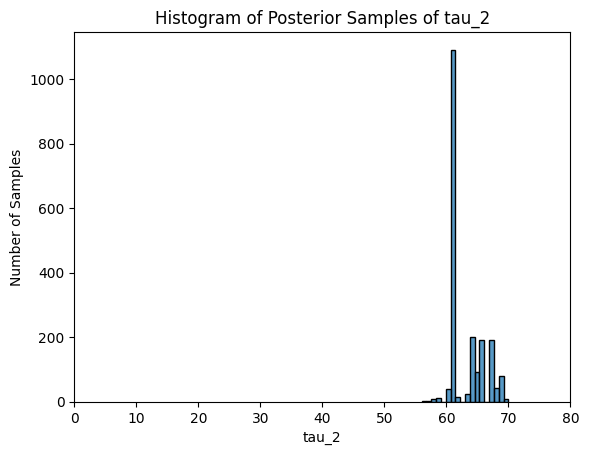


Mean of lambda_1: 17.063852209041627
94% HDI of lambda_1: [15.69482114 18.4503709 ]


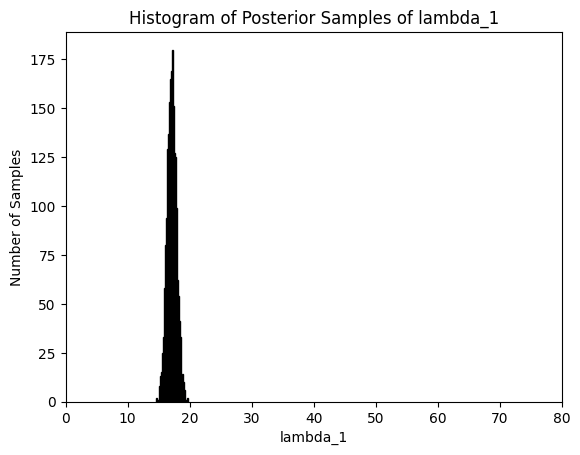


Mean of lambda_2: 10.43225281868465
94% HDI of lambda_2: [ 9.28130353 11.53949614]


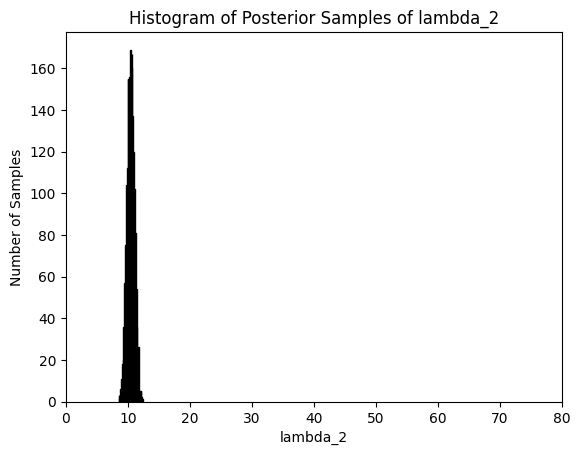


Mean of lambda_3: 14.923616208641993
94% HDI of lambda_3: [13.08796345 16.68685654]


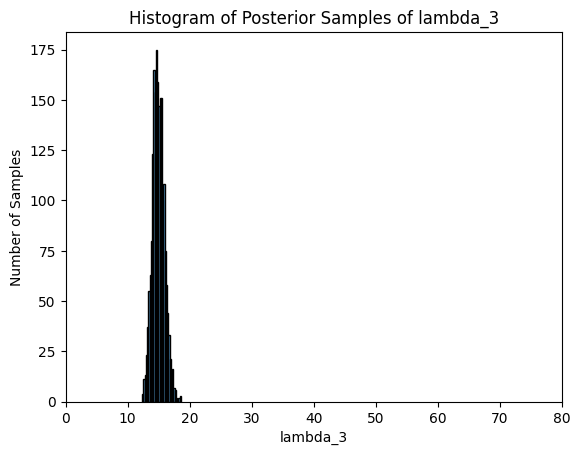

In [18]:
# YOUR CODE GOES HERE
for param_name in param_names:
    plot_posterior(param_name,  trace_adjusted )
    plt.show()


**Enter answer here:** i) The current model is now a good fit for the model because the ranges of HDI are narrow so there is  a lot of confidence for the posterior.
Since lambda 2 is less than lambda 3 the increase aligns with the increasing trend observed after the 2 switchpoint in (a).
ii) The histograms of the posterior samples align because switchpoint beliefs are concentrated around our expectations from the observed trends.

# Q2

In [10]:
topic_df = pd.read_csv('https://raw.githubusercontent.com/MIE223-2024/course-datasets/main/topic_dataset.csv')
topic_df["preprocessed"] = topic_df["preprocessed"].apply(lambda x: ast.literal_eval(x))
topic_df.head()

,document,preprocessed
0,Hi Xperts!\n\nHow can I move the cursor with t...,"[xperts, cursor, keyboard, cursor, key, mouse,..."
1,Where can I obtain a copy of the Open Look wid...,"[obtain, copy, open, look, widget, obtainable,..."
2,\nYou're right about the signal being strong. ...,"[right, signal, strong, live, west, philadelph..."
3,"\nHe's a Canadian ""thing"". Former coach of the...","[canadian, thing, coach, boston, bruin, colora..."
4,"\n\n Heck, I seem to feel like that *ev...","[heck, feel, like, time, including, cafeteria,..."


## (a)

In [11]:
## YOUR CODE GOES HERE
#preprocess#remove stopwords#

# Build the id2word dictionary and the corpus (map the word to id)

texts = topic_df["preprocessed"]
dictionary = corpora.Dictionary(texts)
print('Number of unique tokens: ', len(dictionary))

# Remove stop words from a stop words set; merged from nltk and scikit-learn's built-in list and words
stoplist = set(stopwords.words('english')).union(set(ENGLISH_STOP_WORDS))
stop_ids = [dictionary.token2id[stopword] for stopword in stoplist
            if stopword in dictionary.token2id]
dictionary.filter_tokens(stop_ids)

# Filter out words that appear in less than 2 documents (appear only once)
# There's also a no_above argument that we could specify, e.g. no_above = 0.5 would remove words that appear in more than 50% of the documents
dictionary.filter_extremes(no_below = 2, no_above = 0.5)

# Remove gaps in id sequence after words that were removed
dictionary.compactify()
print('Number of unique tokens: ', len(dictionary))

# Convert words to the "learned" word id
corpus = [dictionary.doc2bow(text) for text in texts]

Number of unique tokens:  49388
Number of unique tokens:  25104


## (b)

In [12]:
# Train LDA model

# YOUR CODE GOES HERE
topic_model = LdaModel(corpus, id2word = dictionary, num_topics = 10, iterations = 100, eval_every = None, random_state = 100, minimum_probability = 0)


In [13]:
# Display LDA visualization

# YOUR CODE GOES HERE
lda_topic_diagram = pyLDAvis.gensim_models.prepare(topic_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_topic_diagram)
lda_topic_diagram

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.157940 -0.000224       1        1  11.524367
1     -0.031282  0.131222       2        1   3.631323
2     -0.103395  0.098031       3        1   3.668419
3     -0.058367 -0.089745       4        1  14.019759
4     -0.063127 -0.040531       5        1   7.489208
5      0.218932 -0.049154       6        1  12.205720
6     -0.000439  0.125442       7        1  12.587743
7      0.055963 -0.008531       8        1  20.780284
8     -0.134138 -0.116949       9        1   3.078887
9     -0.042088 -0.049562      10        1  11.014289, topic_info=          Term         Freq        Total Category  logprob  loglift
680   armenian  1765.000000  1765.000000  Default  30.0000  30.0000
127       game  2112.000000  2112.000000  Default  29.0000  29.0000
2593    israel   899.000000   899.000000  Default  28.0000  28.0000
89        team  1408.000000  1408.000000  Default  27.0000  27.0000
291     window  1868.000000  1868.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
98        work   243.840425  1691.069126  Topic10  -5.7649   0.2694
76       right   236.103419  2030.270047  Topic10  -5.7972   0.0543
1627      sure   208.255497  1017.279740  Topic10  -5.9227   0.6199
46        good   219.164541  2081.262808  Topic10  -5.8716  -0.0449
13        need   210.361957  1552.768804  Topic10  -5.9126   0.2070

[872 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
2633       8  0.982931      abiding
12172      2  0.945526  accelerated
13374      1  0.074588  accelerator
13374      6  0.909969  accelerator
2123       1  0.059129         adam
...      ...       ...          ...
1131       7  0.233432         zone
1131       8  0.006484         zone
1131       9  0.071327         zone
1131      10  0.038905         zone
14989      9  0.979837         zoom

[3684 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

## (c)

**Enter answer here:** distinct topics chosen : Topic 3, Topic 8 and Topic 9, then top 5 salient words are for these topics are ->
**Topic 3**
power, play, period, time, like, good
Since these are the top most salient terms the topic might be related to a sport.
**Topic 6**
window, file, server, program, available
Since these are the top most salient words the topic might be related to a computer program
**Topic 9**
armenian, azerbaijan,right,people, azeri
Since these are the top most salient words the topic miight be related to amernian-azerbaijan conflict for rights
